# Goal of the project
The goal of this project is to learn a policy for an inverted pendulum model to make it do a swing-up motion. Beyond the task of inverting a pendulum, the goal is to also gain an understanding on how Q-learning works, its limitations and advantages.

To make the problem interesting, the inverted pendulum has a limit on the maximum torque it can apply, therefore it is necessary for the pendulum to do a few "back and forth" motions to be able to reach the inverted position ($\theta=\pi$) from the standing still non-inverted position ($\theta=0$). 

<img src='pendulum.png' width="120">

In the following, we will write $x = \begin{pmatrix} \theta \\ \omega \end{pmatrix}$ as the vector of states of the system. We will also work with time-discretized dynamics, and refer to $x_n$ as the state at time $t = n \Delta t$ (assuming discretization time $\Delta t$)

We want to minimize the following discounted cost function
$$\sum_{i=0}^{\infty} \alpha^i g(x_i, u_i)$$ where 
$$g(x_i, u_i) = (\theta-\pi)^2 + 0.01 \cdot \dot{\theta}_i^2 + 0.0001 \cdot u_i^2 \qquad \textrm{and} \qquad\alpha=0.99$$
This cost mostly penalizes deviations from the inverted position but also encourages small velocities and control.

## Q-learning with a table
In the first part, we will implement the Q-learning algorithm with a table. To that end, we are given a robot (defined in the package ```pendulum.py```) with a function ```get_next_state(x,u)``` that returns $x_{n+1}$ given $(x_n, u_n)$. We will assume that $u$ can take only three possible values. Note that $\theta$ can take any value in $[0,2\pi)$ and that $\omega$ can take any value between $[-6,6]$. 

In order to build the table, we will need to discretize the states. So for the learning algorithm we will use 50 discretized states for $\theta$ and 50 for $\omega$. Keep in mind that the real states of the pendulum used to generate an episode will not be discretized.


1. Write a function ```get_cost(x,u)``` that returns the current cost $g(x,u)$ as a function of the current state and control.

2. What is the dimension of the Q-table that you will need to implement (as a numpy array)? Why?

3. How can you compute the optimal policy from the Q-table? And the optimal value function? Write a function ```get_policy_and_value_function(q_table)``` that computes both given a Q-table as an input.

4. Write a function ```q_learning(q_table)``` that implements the tabular Q-learning algorithm (use episodes of 100 timesteps and an epsilon greedy policy with $\epsilon=0.1$). The function should get as an input an initial Q-table  and return a learned Q-table of similar size. Use the function ```get_next_state``` from the pendulum package to generate the episode (do not discretize the real state of the pendulum!). During learning store the cost per episode to track learning progress.

5. How many epsilodes (approximately) does it take for Q-learning to learn how to invert the pendulum when $u \in \{-4,0,4\}$? (use a learning rate of 0.1). Show the learning progress in a plot.

6. Using the simulate / animate functions (cf. below) how many back and forth of the pendulum are necessary to go from $x = [0,0]$ to the fully inverted position? Plot the time evolution of $\theta$ and $\omega$. 

7. Plot the found policy and value function as 2D images (cf. below).

8. Answer questions 5 to 7 when using $u \in \{-5,0,5\}$. What quantitative differences do you see between the computed policies in 5. and 8.? Can you explain?

9. How is learning affected when changing $\epsilon$ and the learning rate? Why?

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import pendulum

In [2]:
# we can get the integration step used in the simulation
print(f'dt is {pendulum.DELTA_T}')

# we can get the size of its state and control vector
print(f'number of states {pendulum.NUMBER_STATES} and number of controls {pendulum.NUMBER_CONTROLS}')
print('the states are indexed as follows: theta, omega')

# we can get the maximum velocity of the pendulum (omega)
print(f'the max velocity is {pendulum.MAX_VELOCITY} rad/seconds')

dt is 0.1
number of states 2 and number of controls 1
the states are indexed as follows: theta, omega
the max velocity is 6.0 rad/seconds


In [3]:
# the next_state function allows to compute the next state given a current state and action
# This is going to be very helpful to run an episode!

# assume we set x = [theta, omega] = [0,0] and u = 5, we can get the next state using
x = np.array([0.,0.])
u = 5
x_next = pendulum.get_next_state(x, u)

print(f'the next state is {x_next}')

the next state is [0.02227801 0.48969119]


In [4]:
def get_cost(x, u):
    r = np.square(x[0] - np.pi) + 0.01*np.square(x[1])+ 0.0001*np.square(u)
    return r

In order to build the table, we will need to discretize the states. So for the learning algorithm we will use 50 discretized states for  𝜃  and 50 for  𝜔 . Keep in mind that the real states of the pendulum used to generate an episode will not be discretized.

2500*3

In [5]:
def find_q_table_index(x):
    theta = np.linspace(0, 2*np.pi, num=50, endpoint=False)
    omega = np.linspace(-6, 6, num=50, endpoint=True)
    picked_theta_interval = theta[(theta >= x[0]-2*np.pi/50) & (theta <= x[0])]
    picked_omega_interval = omega[(omega >= x[1]-12/49) & (omega <= x[1])]
    theta_index = np.where(theta==picked_theta_interval)
    omega_index = np.where(omega==picked_omega_interval)
    return theta_index[0], omega_index[0]
def find_q_value_list(x,q_table):
    theta_index, omega_index = find_q_table_index(x)
    index = theta_index*50+omega_index
    q_value_list = q_table[:,index]
    return q_value_list

def find_q_value(x, action, q_table, action_space):
    theta_index, omega_index = find_q_table_index(x)
    q_value = q_table[action_space.index(action),theta_index*50+omega_index]
    return q_value
def greedy_policy(x,q_table,action_space):
    epsilon = 0.1
    
    if np.random.uniform() <= epsilon:
        action = np.random.choice(action_space)
    else:
        q_value_list = find_q_value_list(x,q_table)
        action=action_space[np.argmin(q_value_list)]
    return action
def compute_value(x, action, q_table, action_space, alpha, gamma):
    x_next = pendulum.get_next_state(x, action)
    q_value_ = find_q_value(x, action, q_table, action_space)
    delta = get_cost(x,action) +  alpha * min(find_q_value_list(x_next,q_table)) - find_q_value(x, action, q_table, action_space)
    Q_value = q_value_ + gamma * delta
    return Q_value, x_next
def get_policy_and_value_function(x, q_table, action_space, alpha, gamma):
    action = greedy_policy(x,q_table,action_space)
    Q_value, x_next = compute_value(x, action, q_table, action_space, alpha,gamma)
    return action, Q_value, x_next

In [6]:

def q_learning(q_table, action_space):
    alpha = 0.99
    gamma = 0.1
    cost_list = []
    episodes = 5000
    for i in range(episodes):
        x = np.array([0.,0.])
        cost = 0
        for _ in range(100):
            action, Q_value, x_next = get_policy_and_value_function(x, q_table, action_space, alpha, gamma)
            cost += alpha * get_cost(x,action)
            theta_index, omega_index = find_q_table_index(x)
            q_table[action_space.index(action),theta_index*50+omega_index] = Q_value
            x = x_next
        cost_list.append(cost)
    return cost_list, q_table

In [7]:
q_table = np.random.rand(3,2500)
action_space = [-4,0,4]
cost_list, q_table = q_learning(q_table, action_space)

In [19]:
import matplotlib.pyplot as plt

plt.plot(np.arange(5000),cost_list)
plt.show()

In [9]:
# we can also simulate the robot but we need to provide a controller of the following form
def dummy_controller(x):
    """
        the prototype of a controller is as follows
        x is a column vector containing the state of the robot
        
        this controller needs to return a scalar
        you may want to modify this controller to use the policy table to compute control output
    """
    # here we do nothing and just return a 0 control
    return 0.

def control_policy(x,q_table):
    epsilon = 0.1
    action_space = [-4,0,4]
    if np.random.uniform() <= epsilon:
        action = np.random.choice(action_space)
    else:
        q_value_list = find_q_value_list(x,q_table)
        action=action_space[np.argmin(q_value_list)]
    return action
    
    

# we can now simulate for a given number of time steps - here we do 10 seconds
T = 10
x0 = np.array([1.4,0.])
t, x, u = pendulum.simulate(x0, control_policy, T, q_table)

<IPython.core.display.Javascript object>


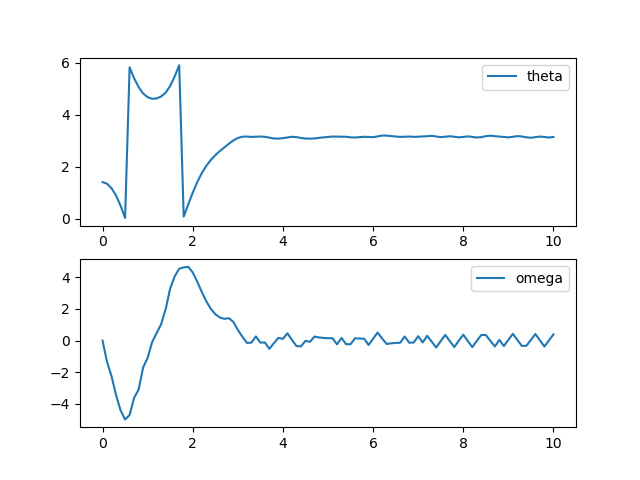

<IPython.core.display.Javascript object>


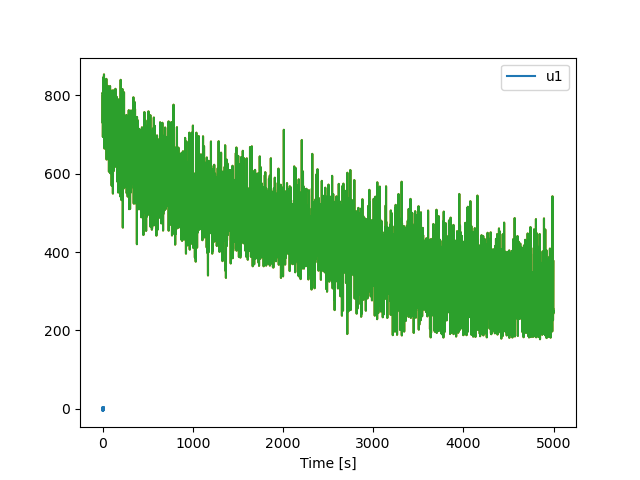

Text(0.5, 0, 'Time [s]')

In [17]:
# we can plot the results
plt.figure()

plt.subplot(2,1,1)
plt.plot(t, x[0,:])
plt.legend(['theta'])

plt.subplot(2,1,2)
plt.plot(t, x[1,:])
plt.legend(['omega'])

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1'])
plt.xlabel('Time [s]')

In [11]:
# now we can also create an animation
pendulum.animate_robot(x)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAfZBtZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xOSBsb29rYWhlYWRfdGhy
ZWFkcz0zIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA6PZYiEABD//veBvzLL
XyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAUeHteuN3YNbSdAAABrAA6Qix/9vpDjcAE/ZYPzW
Iy/xaAfWoiuIxPmK2D7zN1SWOL4zZ8ixj9mJWyafzaQPJPgumMKQ5V59n8tUzfUDS0tnaGINepwN
ygSCAo62Nj0Ixhv5SVoJFUYpmvY7OlceVopm0K7e9iLYzS+7C8RJRANe5oQnlmwO88l0TgfHNasA
cBupheGfaeEXLZmHWO+X2fTyHC+vtQ7TaNefQ7CHnR1luQXnqFHjCK9efiyP+qu6t8Lv5Q2TfbSJ
Uzs0SeYcbqwmukz92HSdD7mvf05DpwdQWbSEHWRNjTXhumQVil9qnvK4qtsUvcIMXzoSTSbemIa1
zJu841W2+V44G5B3MZ0BrlgHnYsCWKot35uLoxydIpjYWg9+7lBp1dLoRR8HR6ljB55JGWL+XQwN
sLum9zkPSkcJ+V/Ngl3Qa8E35Nz34JkIu35PUQAXNmP5a/sJO/zRhyFusW1qwkI1iN5DIJp2XQqA
bPb8kSwU6QlSI+2r/Ap+Q0l5RJ/0nftzawE1OQzWCRSL/fGQO94rq9bladJxrF8QRZSdR9vuHOb9
LHOidxh0CfkFn1zDDKZ6xn6mDvAAWWi6LbBQfyx5GxcLoqexfshUiZjj4579qehLAs2eJLYzPFtX
V2hBtrLktP6rM42xUGNNvgCK9lWqUHPfylVqvIfGtIRw6IX0wv+Ip+06gR3/FKUAAAMBs4COksTH
IEl9LnVkDcC5l1ionKhG+MbpLMvrAzwqhcs4sFOqZ3KWxcV+vFEsSQ8wkAL+V8BKgzH2ASIv29kp
iiht8ZvG4bd8uR79qE1FqeAk5pfFUnaB6zO6UwhSBDKTUM1lMmrUFLvGD4rlIqCHsFjduGD2KPA1
iP34Rv9JkAnzUcr/k2emqRU9EoLbicGoOMAZJwtiVcotVv+c0HKt6+sr5w7VsNF9OXbrv97ClUZd
8t7BqCwra6tWF6QOvnYeuO9f/l5qUFYN9vz1w07+RfUHkR5a3tKo4gSU89aPdDFazntPReXBRpfb
OQ5tPpYz8yDN563/r3SW1E1mKuJ8yJoFNwYz2YynItCD/qerjBaapJvRY399f9kYe5ql7sUjEh3x
r0pcQBK21mkWaRiCyI8Kova5y58T+oFJpHBLJ8BFNVsaKOx4jm5uSX8oU67zwJYqTycMHeo+rEQH
Y6xvMH9iGOzkm9jyoIEK55hpKLSnVMR5GXdZxGSyXrxnjY8kzXlqf7YLsK2F1UPaEQcr4eK1jaGw
1rWehE/XQD0aEsyq6Zl1wksyU/hg7Zuu7CFW/jq6yRt9xJ2FsRWVyE/TnvMehRCxvtdyRWI4GZEh
Ou02CkaEk9YZY6/pbaqfjM+aUcABONo+JCw2S+sHXBbx3l9scNX3tiIY9eeBcC+Aj+NDQ8zlZOaR
Oplj1RYuKQpSynrapPZg4t0KCtBgF8NuUQIOCpbFD1jWKAkZZEVkC0U0OB/GBGT66z+y7KbtFOml
0Mw/hVEmUOrzhYjJyDMRBawcLIcBgKOvk3oFKIYdknJQuRdL4SqJp82jyI/yzk97zTCTsmq7H0GY
AwXKkEoeGpdfFLZ+QRTv2WG1NNuOdjnZkAK6cBNvcvz9x0XZmAsTZfhVO71KC9b9cMpEMP2MpZgS
D3AyMHxUd6NAEbuDrKOQJ386ar+UIcTi61n6n6zQh4r9tJOS4vXKULBfHlRg0r4eLiO8KvaSdsfI
HNvXSVvRLzr1n8JoRROXnvQjUApX+oS8xsHFROb9tPwmE/1PzCIs6gbOaV3er8XvA2jmyfx1jsqp
/1uw55ldO+SIgg9nIdGtAal0KANUwAdvAk3zzV2vlW3m2uST45zy+fORJz6p/BP1L23RWVzriY/Y
vFjX8k3ShIF9q1O/09GrZLPeSBGzCW0m2ZFCiD85mr9NiEbtzoF1vnDCfbwl6ZnaDScwphDLDGsg
B9lCPTvd/KEv2qNAJzcL052fI3pABrP/1JTZdeIOtUKv5k1mNsYqbVQ285pDUS/+u7B7qrsrkn7L
swD5nI7sisjhf3QJzj1VqRUg471ZX70FBinPA1gE3zMUzT01bsa3I6j44wP4oiEXElkKkE8HOECT
4C393/l7s3qSrwk2N39FuNNqLntB6HwjMaUUaMUkd/DupMrcucjgSZ7CYimItQQhIdNgQNzmua7O
u84mFUV+QdR7G6AMA1ECVTbTgd1TRU8KkbXVuDutu7qu64tO691Hy/BaaT3FE+OFPtVCkjH7MtIa
ZgDZARHgyWaRkFQWssOoYZnp/BQpO14nEHQbmIpC/skJbBS0HfiHPQTSU+af1leubs4JihKgQP7y
rPxiv3gb1vBnsWe4XQrbQcDR5PDi+uqdvKZtDsjN6SHZG2BWvGWv10hWxCkVqYLCjE6xM/Q11Hzz
Xz8lwHeMRvsAHMOT+lvTqXQkl+dF/hmbmicsoVs2mjiyCForWJoo3fLRnKf6v7WsWnUG3lLpl6VO
jwItc+XgBtizF96ibrSrCZmHc91Zqu1Erds/VN7ip+w54UHGamjXaOzCrBOq8lXkNhgbZc8sgyrD
WZodkEwjdydQ8VSa/LVDjRu6iN5KrrkQD39c6ozduds+5PyXkkvrAxvHg0v4EKAIk2SKLQ3CZy3J
tP6s0f0knWImh8mZDzvXhptOXKxSD6QfaYznZtX0GEqw2gpI47A6EIAofOxJ6I1ZFNoQoiIOeO1o
ppGZylK665lv9Kpu0Zytlr/8ISI2vm2hUvQNLCLltSGFUTyHaay1EMVfz5MuO/cxpnF3gGxOaOyX
PE/pUc6tm7FgRJZI3G7AzWzrf1KbBuz3bOdWw7C55z2GJNZxdZW+v8tJRiKBiO36jIPICeSRuEwX
HkqDVHBSkfl4WScYBriYt

We also need to discretize the state space, we discretize $\theta \in [0, 2\pi]$ in 50 states and $\dot{\theta} \in [-6, 6]$ is 50 states. For example:

In [12]:
# we don't want 2pi to be in the set because it's the same as 0
# we generate 50 equally spaced points for theta
discretized_theta = np.linspace(0, 2*np.pi, 50, endpoint=False)

# we generate 50 equally spaced points for omega
discretized_omega = np.linspace(-6, 6, 50)

# now given an arbitrary continuous state theta
theta_arbitrary = 0.6234
omega_arbitrary = 1.234

# we can find the index of the closest element in the set of discretized states
index_in_discretized_theta = np.argmin(np.abs(np.sin(discretized_theta - theta_arbitrary)))
index_in_discretized_omega = np.argmin(np.abs(discretized_omega - omega_arbitrary))

# and find the closed discretized state
closest_theta_state = discretized_theta[index_in_discretized_theta]
closest_omega_state = discretized_omega[index_in_discretized_omega]

print(f'the discretized theta closest to {theta_arbitrary} is {closest_theta_state} with index {index_in_discretized_theta}')
print(f'the discretized omega closest to {omega_arbitrary} is {closest_omega_state} with index {index_in_discretized_omega}')

the discretized theta closest to 0.6234 is 0.6283185307179586 with index 5
the discretized omega closest to 1.234 is 1.3469387755102042 with index 30


In [13]:
optimal_value = np.amax(q_table,axis=0)
optimal_policy = np.argmax(q_table,axis=0)

In [14]:
value_function = optimal_value.reshape(50,50)
policy = optimal_policy.reshape(50,50)

<IPython.core.display.Javascript object>


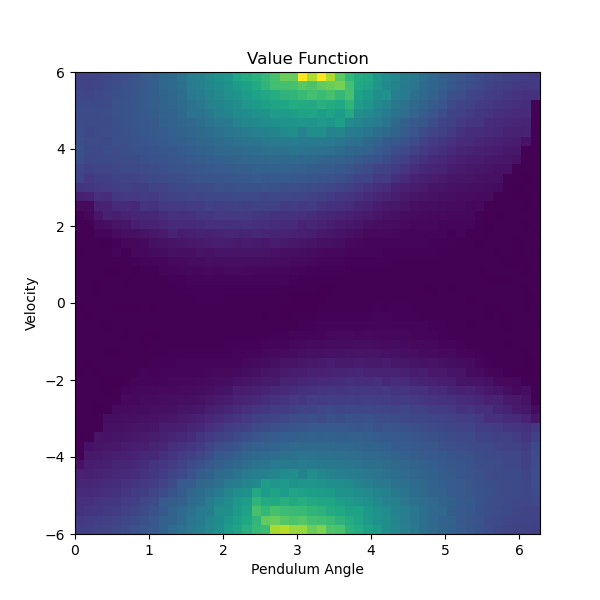

<IPython.core.display.Javascript object>


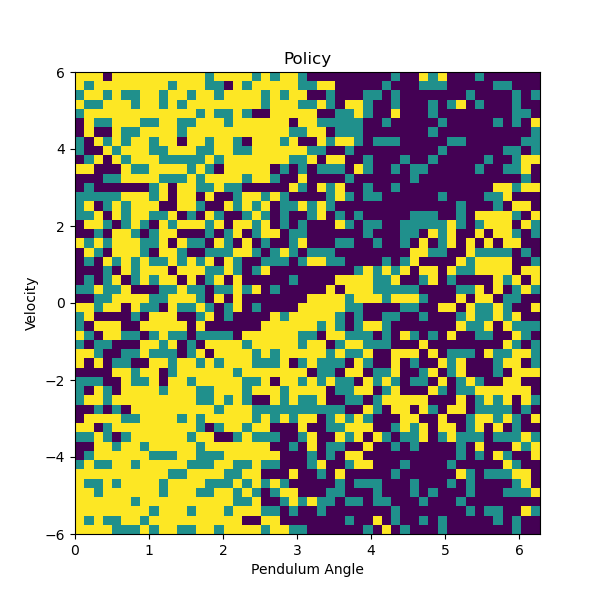

Text(0.5, 1.0, 'Policy')

In [16]:
# # here is some code to plot results, assuming a policy and a value function are given
# # this can be used to answer questions in both Part 1 and 2

# value_function = np.zeros([50,50])
# policy = np.zeros([50,50])

# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(value_function, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(policy, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')